In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder
import collections
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
np.random.seed(42)
import tensorflow as tf
# Resource: https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

In [ ]:
processed_data = pd.read_csv('data.csv')

In [ ]:
processed_data

,AveragePaymentValue,CustomerKey,DueDate,EarliestPaymentDate,InvoiceKey,NumPayments,OriginalInvoiceAmount,LatestPaymentDate,PaymentType,TotalPaymentValue,RaisedDate,StatementTransactionType
0,168.000,16745090,2018-03-02,2018-11-23,195519971,1.0,168.00,2018-11-23,Barclays Multi,168.00,2018-01-03,INV
1,819.600,16743947,2018-02-03,2018-10-26,196442471,1.0,819.60,2018-10-26,Barclays Multi,819.60,2018-01-04,INV
2,718.200,16836264,2018-02-08,2018-11-05,196563186,1.0,749.40,2018-11-05,Barclays Multi,718.20,2018-01-09,INV
3,1873.080,16843107,2018-03-02,2018-09-04,196711370,1.0,1873.08,2018-09-04,Barclays Multi,1873.08,2018-01-11,INV
4,1316.090,16739410,2018-02-11,2018-09-26,197134638,1.0,1316.09,2018-09-26,Barclays Multi,1316.09,2018-01-12,INV
...,...,...,...,...,...,...,...,...,...,...,...,...
272237,24.815,16849111,2019-07-30,2019-07-30 00:00:00,196911580,2.0,49.63,2019-08-30 00:00:00,Barclays Multi,49.63,2019-06-30,INV
272238,178.165,16847651,2019-07-30,2019-09-24 00:00:00,195362531,2.0,356.33,2019-10-07 00:00:00,Barclays Multi,356.33,2019-06-30,INV
272239,36.310,16917308,2019-07-30,2019-07-29 00:00:00,196871858,2.0,72.62,2019-08-09 00:00:00,Barclays Multi,72.62,2019-06-30,INV
272240,311.440,16782671,2019-07-30,2019-07-22 00:00:00,195891626,2.0,311.44,2019-09-18 00:00:00,CheckM8,622.88,2019-06-30,INV


In [ ]:
# Drop unnecessary columns
#processed_data = processed_data.drop(['ExtractDate'], axis = 1)

# Set date values to datetime
processed_data["RaisedDate"] = pd.to_datetime(processed_data["RaisedDate"])
processed_data["DueDate"] = pd.to_datetime(processed_data["DueDate"])
processed_data["EarliestPaymentDate"] = pd.to_datetime(processed_data["EarliestPaymentDate"])
processed_data["LatestPaymentDate"] = pd.to_datetime(processed_data["LatestPaymentDate"])

# Drop NA
processed_data = processed_data.dropna()

# Reset Index
processed_data = processed_data.reset_index()

In [ ]:
processed_data

,index,AveragePaymentValue,CustomerKey,DueDate,EarliestPaymentDate,InvoiceKey,NumPayments,OriginalInvoiceAmount,LatestPaymentDate,PaymentType,TotalPaymentValue,RaisedDate,StatementTransactionType
0,0,168.000,16745090,2018-03-02,2018-11-23,195519971,1.0,168.00,2018-11-23,Barclays Multi,168.00,2018-01-03,INV
1,1,819.600,16743947,2018-02-03,2018-10-26,196442471,1.0,819.60,2018-10-26,Barclays Multi,819.60,2018-01-04,INV
2,2,718.200,16836264,2018-02-08,2018-11-05,196563186,1.0,749.40,2018-11-05,Barclays Multi,718.20,2018-01-09,INV
3,3,1873.080,16843107,2018-03-02,2018-09-04,196711370,1.0,1873.08,2018-09-04,Barclays Multi,1873.08,2018-01-11,INV
4,4,1316.090,16739410,2018-02-11,2018-09-26,197134638,1.0,1316.09,2018-09-26,Barclays Multi,1316.09,2018-01-12,INV
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272237,272237,24.815,16849111,2019-07-30,2019-07-30,196911580,2.0,49.63,2019-08-30,Barclays Multi,49.63,2019-06-30,INV
272238,272238,178.165,16847651,2019-07-30,2019-09-24,195362531,2.0,356.33,2019-10-07,Barclays Multi,356.33,2019-06-30,INV
272239,272239,36.310,16917308,2019-07-30,2019-07-29,196871858,2.0,72.62,2019-08-09,Barclays Multi,72.62,2019-06-30,INV
272240,272240,311.440,16782671,2019-07-30,2019-07-22,195891626,2.0,311.44,2019-09-18,CheckM8,622.88,2019-06-30,INV


In [ ]:
# Create onehot encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# One Hot Encode Categorical Variables
# Statement Transaction Type
enc_df = pd.DataFrame(data = enc.fit_transform(processed_data[['StatementTransactionType']]).toarray(), columns = enc.categories_)
processed_data = processed_data.join(enc_df)

print("Encoded statement transaction type.")

# Payment Type
enc_df = pd.DataFrame(data = enc.fit_transform(processed_data[['PaymentType']]).toarray(), columns = enc.categories_)
processed_data = processed_data.join(enc_df)
print("Encoded payment type.")

Encoded statement transaction type.
Encoded payment type.


In [ ]:
# Generate some variables for dates
processed_data["PaymentPercentage"] =  processed_data["AveragePaymentValue"] / processed_data["OriginalInvoiceAmount"]
processed_data["PaymentTimeRemaining"] = (processed_data["DueDate"] - processed_data["LatestPaymentDate"]).astype('timedelta64[D]')
processed_data["1stPaymentTimeRemaining"] = (processed_data["DueDate"] - processed_data["EarliestPaymentDate"]).astype('timedelta64[D]')
processed_data["PaymentWindow"] = (processed_data["DueDate"] - processed_data["RaisedDate"]).astype('timedelta64[D]')

In [122]:
processed_data

,index,AveragePaymentValue,CustomerKey,DueDate,EarliestPaymentDate,InvoiceKey,NumPayments,OriginalInvoiceAmount,LatestPaymentDate,PaymentType,TotalPaymentValue,RaisedDate,StatementTransactionType,"(CSH,)","(INV,)","(JRN,)","(Barclays Multi,)","(CheckM8,)","(['Barclays Multi' 'CheckM8'],)",PaymentPercentage,PaymentTimeRemaining,1stPaymentTimeRemaining,PaymentWindow
0,0,168.000,16745090,2018-03-02,2018-11-23,195519971,1.0,168.00,2018-11-23,Barclays Multi,168.00,2018-01-03,INV,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-266.0,-266.0,58.0
1,1,819.600,16743947,2018-02-03,2018-10-26,196442471,1.0,819.60,2018-10-26,Barclays Multi,819.60,2018-01-04,INV,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-265.0,-265.0,30.0
2,2,718.200,16836264,2018-02-08,2018-11-05,196563186,1.0,749.40,2018-11-05,Barclays Multi,718.20,2018-01-09,INV,0.0,1.0,0.0,1.0,0.0,0.0,0.958367,-270.0,-270.0,30.0
3,3,1873.080,16843107,2018-03-02,2018-09-04,196711370,1.0,1873.08,2018-09-04,Barclays Multi,1873.08,2018-01-11,INV,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-186.0,-186.0,50.0
4,4,1316.090,16739410,2018-02-11,2018-09-26,197134638,1.0,1316.09,2018-09-26,Barclays Multi,1316.09,2018-01-12,INV,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-227.0,-227.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272237,272237,24.815,16849111,2019-07-30,2019-07-30,196911580,2.0,49.63,2019-08-30,Barclays Multi,49.63,2019-06-30,INV,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,-31.0,0.0,30.0
272238,272238,178.165,16847651,2019-07-30,2019-09-24,195362531,2.0,356.33,2019-10-07,Barclays Multi,356.33,2019-06-30,INV,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,-69.0,-56.0,30.0
272239,272239,36.310,16917308,2019-07-30,2019-07-29,196871858,2.0,72.62,2019-08-09,Barclays Multi,72.62,2019-06-30,INV,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,-10.0,1.0,30.0
272240,272240,311.440,16782671,2019-07-30,2019-07-22,195891626,2.0,311.44,2019-09-18,CheckM8,622.88,2019-06-30,INV,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,-50.0,8.0,30.0


In [118]:
# Create x using only numerical columns
clustering_data = processed_data.drop(["index", "CustomerKey","DueDate", "EarliestPaymentDate", "InvoiceKey","LatestPaymentDate", "RaisedDate", "PaymentType","StatementTransactionType"], axis = 1) 

In [119]:
clustering_data

,AveragePaymentValue,NumPayments,OriginalInvoiceAmount,TotalPaymentValue,"(CSH,)","(INV,)","(JRN,)","(Barclays Multi,)","(CheckM8,)","(['Barclays Multi' 'CheckM8'],)",PaymentPercentage,PaymentTimeRemaining,1stPaymentTimeRemaining,PaymentWindow
0,168.000,1.0,168.00,168.00,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-266.0,-266.0,58.0
1,819.600,1.0,819.60,819.60,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-265.0,-265.0,30.0
2,718.200,1.0,749.40,718.20,0.0,1.0,0.0,1.0,0.0,0.0,0.958367,-270.0,-270.0,30.0
3,1873.080,1.0,1873.08,1873.08,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-186.0,-186.0,50.0
4,1316.090,1.0,1316.09,1316.09,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,-227.0,-227.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272237,24.815,2.0,49.63,49.63,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,-31.0,0.0,30.0
272238,178.165,2.0,356.33,356.33,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,-69.0,-56.0,30.0
272239,36.310,2.0,72.62,72.62,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,-10.0,1.0,30.0
272240,311.440,2.0,311.44,622.88,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,-50.0,8.0,30.0


In [125]:
payment_data = clustering_data.drop(['PaymentTimeRemaining','1stPaymentTimeRemaining','PaymentWindow'], axis=1)
transaction_data = clustering_data.drop(['NumPayments','AveragePaymentValue','TotalPaymentValue'], axis=1)

In [126]:
# Scale clustering data.
payment_scaled = scale(payment_data)
transaction_scaled = scale(transaction_data)

In [121]:
payment_scaled.shape

(272242, 11)

In [127]:
transaction_scaled.shape

(272242, 11)

In [152]:
used_data = transaction_scaled

In [153]:
distortions = [] 
covariances = [] 
mapping1 = {} 
mapping2 = {} 
G = range(1,15) 

# Loop 15 times
for g in G: 
    #Building and fitting the model 
    GMModel = GaussianMixture(n_components=g, ).fit(used_data) 
    GMModel.fit(data)     
      
    distortions.append(sum(np.min(cdist(data, GMModel.means_, 
                      'cosine'),axis=1)) / data.shape[0]) 
    covariances.append(GMModel.covariances_) 
  
    mapping1[g] = sum(np.min(cdist(data, GMModel.means_, 
                 'cosine'),axis=1)) / data.shape[0] 
    mapping2[g] = GMModel.covariances_ 

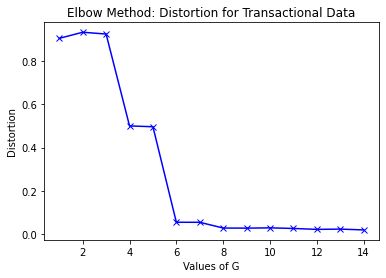

In [154]:
plt.plot(G, distortions, 'bx-') 
plt.xlabel('Values of G') 
plt.ylabel('Distortion') 
plt.title('Elbow Method: Distortion for Transactional Data') 
plt.show() 

In [155]:
# Visualize the results on PCA-reduced data
pca = PCA(2)
reduced_data = pca.fit_transform(used_data)

In [156]:
used_data[0]

array([-0.44315805, -0.01916912,  0.02765159, -0.01992143,  0.33760785,
       -0.33742555, -0.00995923,  0.05828185, -6.12744491, -6.14763631,
        3.97716222])

In [157]:
reduced_data.shape

(272242, 2)

In [172]:
GMModel = GaussianMixture(n_components=4, )
GMModel.fit(reduced_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [173]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

In [174]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 5, reduced_data[:, 0].max() + 5
y_min, y_max = reduced_data[:, 1].min() - 5, reduced_data[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [175]:
Z = GMModel.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

In [176]:
Z

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

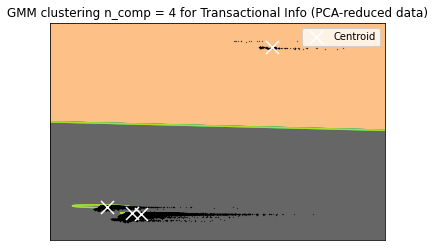

In [177]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
# Plot the centroids as a white X
means = GMModel.means_
plt.scatter(means[:, 0], means[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, label = "Centroid")
plt.contour(xx,yy, Z)
plt.title('GMM clustering n_comp = 4 for Transactional Info (PCA-reduced data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [178]:
GMModel = GaussianMixture(n_components=5, )
GMModel.fit(reduced_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [179]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 5, reduced_data[:, 0].max() + 5
y_min, y_max = reduced_data[:, 1].min() - 5, reduced_data[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [180]:
Z = GMModel.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

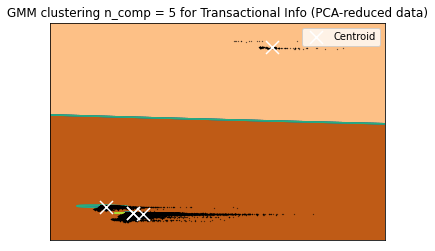

In [182]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
# Plot the centroids as a white X
means = GMModel.means_
plt.scatter(means[:, 0], means[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, label = "Centroid")
plt.contour(xx,yy, Z)
plt.title('GMM clustering n_comp = 5 for Transactional Info (PCA-reduced data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [183]:
GMModel = GaussianMixture(n_components=6, )
GMModel.fit(reduced_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [184]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 5, reduced_data[:, 0].max() + 5
y_min, y_max = reduced_data[:, 1].min() - 5, reduced_data[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [185]:
Z = GMModel.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

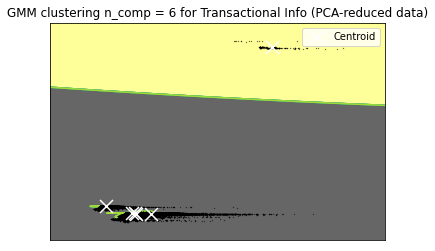

In [186]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
# Plot the centroids as a white X
means = GMModel.means_
plt.scatter(means[:, 0], means[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, label = "Centroid")
plt.contour(xx,yy, Z)
plt.title('GMM clustering n_comp = 6 for Transactional Info (PCA-reduced data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()